In [6]:
import json
from collections import defaultdict

import matplotlib
import pandas as pd
import seaborn as sns

from src.features.n_grams import get_n_grams_mem_eff
from src.utils.tokenizers import tokenizers

%matplotlib inline

In [7]:
from src import PROJECT_PATHS

In [12]:
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks
cufflinks.go_offline()

cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

In [13]:
pd.options.display.max_columns = None

 ### Before feature generation

In [14]:
df = pd.read_csv("../data/preprocessed_strict.csv", index_col=0)

#### Additional processing

In [15]:
df.drop(columns=['CURRENT_TIMESTAMP'], inplace=True)
df.TITLE = df.TITLE.str.lower()
df["TIMESTAMP"] = pd.to_datetime(df['TIMESTAMP'])
print(df.shape)
df.drop(df[df['TITLE'] == 'удалено'].index, inplace=True)
df["TITLE"][df['TITLE'].isnull()] = ''
print(df.shape)

(51416, 11)
(51410, 11)


In [16]:
df.head(2)

TITLE  LIKES  \
0      хорошо быть бабой    245   
1  рим история циклична       3   

                                                TEXT  \
0  \nхорошо быть бабой   загрустила  сфоткала себ...   
1  \nлегионы  легионы \nопоясали страну\nматерят ...   

                                   TAGS  COMMENTS     NICKNAME     TIME_GAP  \
0                ["Девушки", "Счастье"]        38    Viruso4ek  5 лет назад   
1  ["Рим", "История", "Война", "Стихи"]        12  lokibrother  5 лет назад   

                  TIMESTAMP  \
0 2014-12-22 23:52:56+03:00   
1 2014-12-22 23:49:08+03:00   

                                          TEXT_PUNCT            TITLE_PUNCT  \
0  \nхорошо быть бабой - загрустила, сфоткала себ...      Хорошо быть бабой   
1  \nлегионы, легионы \nопоясали страну\nматерят ...  Рим(история циклична)   

   target  
0       0  
1       6

In [17]:
df["HOUR"] = df["TIMESTAMP"].map(lambda x: x.hour)
df["YEAR"] = df["TIMESTAMP"].map(lambda x: x.year)
df["MONTH"] = df["TIMESTAMP"].map(lambda x: x.month)
df["WEEKDAY"] = df["TIMESTAMP"].map(lambda x: x.weekday())
df["WEEK"] = df["TIMESTAMP"].map(lambda x: x.week)

<ipython-input-17-9e8a95b6654e>:5: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



#### EDA

In [18]:
df.head(2)

TITLE  LIKES  \
0      хорошо быть бабой    245   
1  рим история циклична       3   

                                                TEXT  \
0  \nхорошо быть бабой   загрустила  сфоткала себ...   
1  \nлегионы  легионы \nопоясали страну\nматерят ...   

                                   TAGS  COMMENTS     NICKNAME     TIME_GAP  \
0                ["Девушки", "Счастье"]        38    Viruso4ek  5 лет назад   
1  ["Рим", "История", "Война", "Стихи"]        12  lokibrother  5 лет назад   

                  TIMESTAMP  \
0 2014-12-22 23:52:56+03:00   
1 2014-12-22 23:49:08+03:00   

                                          TEXT_PUNCT            TITLE_PUNCT  \
0  \nхорошо быть бабой - загрустила, сфоткала себ...      Хорошо быть бабой   
1  \nлегионы, легионы \nопоясали страну\nматерят ...  Рим(история циклична)   

   target  HOUR  YEAR  MONTH  WEEKDAY  WEEK  
0       0    23  2014     12        0    52  
1       6    23  2014     12        0    52

##### Distributions

In [19]:
def char_len(df, cols):
    statistics_df = pd.DataFrame()
    for col in cols:
        statistics_df[f'len_{col}'] = df[col].str.len()
    return statistics_df

def word_len(df, cols, tokenizer=None):
    if not tokenizer:
        tokenizer = tokenizers['whitespace']
    statistics_df = pd.DataFrame()
    for col in cols:
        statistics_df[f'len_words_{col}'] = df[col].map(lambda x: len(tokenizer(x)))
    return statistics_df

In [20]:
char_len_df = char_len(df, ['TEXT', 'TITLE'])
char_len_df['target'] = df['target']

In [21]:
char_len_plot= char_len_df[['target', 'len_TEXT', 'len_TITLE',
                         ]].groupby('target').agg(['mean', 'median'
                                                   ]).iplot(kind='bar',
                                                            barmode='overlay',
                                                            asFigure=True)
char_len_plot

In [22]:
word_len_df = word_len(df, ['TEXT', 'TITLE'])
word_len_df['target'] = df['target']

In [23]:
word_len_plot = word_len_df[['target', 'len_words_TEXT', 'len_words_TITLE',
                         ]].groupby('target').agg(['mean', 'median'
                                                   ]).iplot(kind='bar',
                                                            barmode='overlay',
                                                            asFigure=True)
word_len_plot

In [24]:
word_len_plot = word_len_df[['len_words_TEXT',
                            'len_words_TITLE']].iplot(kind='hist',
                                                       #barmode='group',
                                                       asFigure=True)
word_len_plot

In [25]:
likes_plot = df[['target', 'LIKES'
                         ]].groupby('target').agg(['mean', 'median'
                                                   ]).iplot(kind='bar',
                                                            barmode='overlay',
                                                            asFigure=True)
likes_plot

In [26]:
comments_plot = df[['target', "COMMENTS"
                         ]].groupby('target').agg(['mean', 'median'
                                                   ]).iplot(kind='bar',
                                                            barmode='overlay',
                                                            asFigure=True)
comments_plot

In [27]:
likes_comments_plot = df[["LIKES", "COMMENTS"]].iplot(kind='hist',
                                                barmode='overlay',
                                                asFigure=True)
likes_comments_plot

##### Statistics

In [28]:
statistics_df = word_len_df.copy()
statistics_df['target'] = df['target']
statistics_df['LIKES'] = df['LIKES']
statistics_df['COMMENTS'] = df['COMMENTS']

In [29]:
statistics_df.groupby('target').agg(['mean', 'median', 'min', 'max', 'std'])

len_words_TEXT                              len_words_TITLE             \
                 mean median min   max         std            mean median min   
target                                                                          
0          117.145923     53   0  2574  191.211683        3.640405      3   0   
1          160.610403     85   0  2683  229.159610        3.710732      3   0   
2          285.494958    146   0  4781  369.401161        4.378343      3   0   
3          276.926491    151   0  4217  346.845978        6.966105      6   0   
4           89.696029     60   0  2225  108.431153        4.746678      4   0   
5          778.418224    645   0  4683  594.619528        4.254671      3   0   
6          113.431031     86   0  3351  133.314026        4.163645      3   0   
7          115.650922     34   0  2850  230.255442        3.513965      3   0   

                           LIKES                                    COMMENTS  \
       max       std        mean median   min    max          std       mean   
target                                                                         
0       26  2.899693  302.830472      1  -626   9172   931.435092  33.191600   
1       26  2.848495  507.977385     12  -215  14798  1133.261619  39.328742   
2       27  3.253911  210.074967      0  -143  16490   802.014837  48.094695   
3       28  4.677470  103.064930     25 -1435   6079   311.074759  32.203262   
4       26  3.456584   56.350520     -4  -905   8013   328.330618  22.172071   
5       27  3.582240  165.070544      2   -93   7319   570.634918  19.088180   
6       26  3.828759   14.042690     -5  -285   4078   173.484282   5.711269   
7       25  2.815977  304.780006      2  -651   9980   903.182717  16.827456   

                                     
       median min   max         std  
target                               
0          11   0  1176   74.204685  
1          12   0  1160   85.956073  
2          17   0  1839  106.250308  
3          17   0  1310   56.207704  
4          13   0   862   35.959693  
5           6   0  1057   51.336192  
6           3   0   175    9.034862  
7           6   0   888   39.727919

In [30]:
target_labels= ['политика', 'помощь', 'дети', 'девушки', 'отношения', 'рассказ', 'стихи', 'юмор']	

##### Correlations

In [31]:
scatter = word_len_df.copy()
scatter['LIKES'] = df['LIKES']
scatter['COMMENTS'] = df['COMMENTS']

In [32]:
scatter.columns

Index(['len_words_TEXT', 'len_words_TITLE', 'target', 'LIKES', 'COMMENTS'], dtype='object')

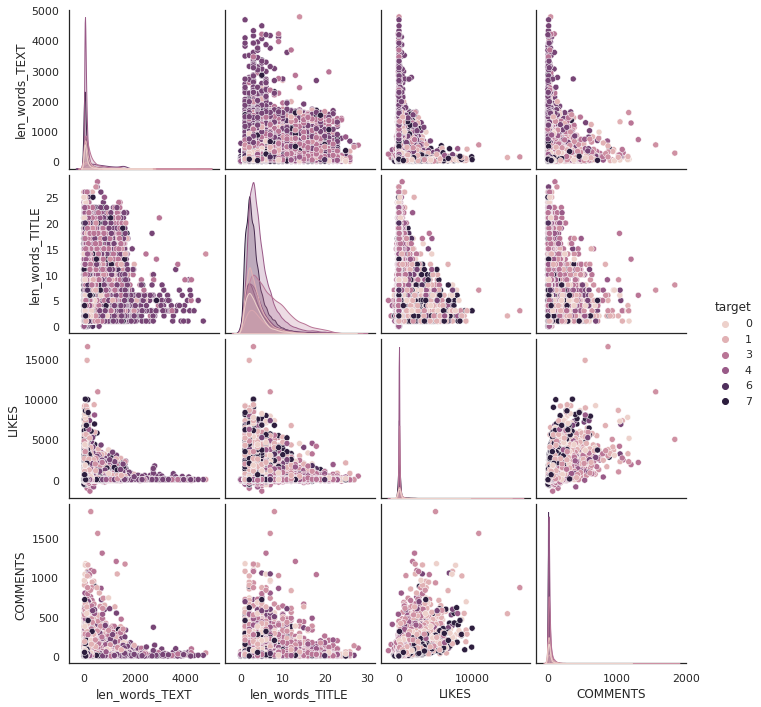

In [33]:
sns.set(
    style="white", 
    palette="muted", 
    color_codes=True
)
sns.pairplot(scatter, 
    hue='target'
)

In [34]:
corrs = scatter.drop(columns=['target']).corr()

In [35]:
import plotly.figure_factory as ff

figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure